# SARIMAX model with non-seasonal order (0,1,1)

## Importing Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# statsmodels library
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

## Reading in the Combined Data (Dengue Cases, Weather & Google Trends)

In [2]:
# load data
dengue_weather_google = pd.read_csv('../../assets/dengue_weather_google.csv', parse_dates=[0], index_col='date')

In [3]:
dengue_weather_google.drop(columns=['index'])

,year,month,number,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),...,vomiting_search,eye_pain_search,joint_pain_search,fever_search,wolbachia_search,headache_search,nausea_search,fogging_search,insect_repellent_search,mosquito_search
date,,,,,,,,,,,,,,,,,,,,,
2014-01-06,2014,1,436,2014,1,6,31.2,10.0,10.8,11.6,...,43,30,27,73,0,22,9,0,1,5.0
2014-01-13,2014,1,479,2014,1,13,0.0,0.0,0.0,0.0,...,38,0,26,66,2,25,11,0,3,5.0
2014-01-20,2014,1,401,2014,1,20,0.0,0.0,0.0,0.0,...,52,12,13,80,0,27,8,0,3,4.0
2014-01-27,2014,1,336,2014,1,27,0.0,0.0,0.0,0.0,...,39,31,0,64,0,25,12,0,3,6.0
2014-02-03,2014,2,234,2014,2,3,0.0,0.0,0.0,0.0,...,31,0,7,72,0,22,8,0,3,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,2018,11,109,2018,11,26,14.4,13.4,13.4,13.4,...,49,12,14,66,1,30,13,30,5,9.0
2018-12-03,2018,12,113,2018,12,3,2.6,1.4,2.0,2.4,...,58,15,10,68,0,27,9,0,2,9.0
2018-12-10,2018,12,107,2018,12,10,0.2,0.2,0.2,0.2,...,59,0,17,61,0,23,13,0,4,8.0


## Train-Test Split Data

In [4]:
dengue_weather_google.columns

Index(['index', 'year', 'month', 'number', 'Year', 'Month', 'Day',
       'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'week', 'dengue_search', 'dengue_fever_search',
       'dengue_symptoms_search', 'rashes_search', 'vomiting_search',
       'eye_pain_search', 'joint_pain_search', 'fever_search',
       'wolbachia_search', 'headache_search', 'nausea_search',
       'fogging_search', 'insect_repellent_search', 'mosquito_search'],
      dtype='object')

In [5]:
# Exo variables
exog_cols = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'dengue_search', 'dengue_fever_search',
       'dengue_symptoms_search', 'rashes_search', 'vomiting_search',
       'eye_pain_search', 'joint_pain_search', 'fever_search',
       'wolbachia_search', 'headache_search', 'nausea_search',
       'fogging_search', 'insect_repellent_search', 'mosquito_search']

In [6]:
# Creating exogenous variables
exog = dengue_weather_google[exog_cols]

In [7]:
# Creating endogenous variables
endog= dengue_weather_google['number']

In [8]:
# Creating test train split 
train_endog = endog[:209]
test_endog = endog[209:]
train_exog = exog[:209]
test_exog = exog[209:]

## Modeling

For the modelling section, we will use SARIMAX model with non seasonal order(0,1,1). We will use different seasonal order to seek the best fit model but keeping period constant at 26.

### Setting Up Functions

In [9]:
# Function for extracting AIC and LLF from SARIMAX summary

def extract_aic_lif(model_fit):
    """
    Extracts the AIC and log-likelihood values from a SARIMAX model summary.
    
    Args:
        model_fit (statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper):
            Fitted SARIMAX model.
    
    Print:
        AIC and log-likelihood values.
    """
    # Get the summary table
    summary = model_fit.summary()
    
    # Extract the AIC and log-likelihood values
    aic = summary.tables[0][2][3]
    llf = summary.tables[0][1][3]
    
    # Print the summary table to the console
    print(summary)
    
    # Print AIC and log-likelihood values
    print("\nAIC:", aic)
    print("Log Likelihood:", llf)
    
    return None


In [10]:
# Function for getting the predicted mean values

def get_predictions_mean(model_fit):
    """
    Gets the predictions from a SARIMAX model.
    
    Args:
        model_fit (statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper):
            Fitted SARIMAX model.
          
    Returns:
        Pandas dataframe containing the predicted mean values and confidence intervals.
    """
    # Get the predictions
    predictions = model_fit.get_prediction(start=len(train_endog), end=len(train_endog) + len(test_exog) - 1, exog=test_exog, index=test_exog.index)
    
    # Get the predicted values mean
    predictions_mean = predictions.predicted_mean
           
    return predictions_mean


In [11]:
# Function for calculating rmse 

def calculate_rmse(predictions_mean):
    """
    Calculates the residuals and RMSE between a set of test and predicted values.
    
    Args:        
        predictions_mean (pandas.core.series.Series):
        Predicted mean values for the test period.
    
    Print:
        RMSE values for the SARIMAX model
    """
    # Calculate the residuals
    residuals = test_endog - predictions_mean
    
    # Calculate the RMSE
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    return None


In [12]:
# Function for plotting predictions_mean and actual values

def plot(predictions_mean):
    """
    Plots the training data, testing data, and predicted values.
    
    Args:        
        Endogenous variable testing data.
        predictions_mean (pandas.core.series.Series):
        Predicted mean values for the test period.
    
    Returns:
        None
    """
    # Set figure size
    plt.figure(figsize=(12,8))

    # Plot training data in blue.
    plt.plot(train_endog, color='blue', label='Train Data')

    # Plot testing data in orange.
    plt.plot(test_endog, color='orange', label='Test Data')

    # Plot predicted values in green.
    plt.plot(predictions_mean, color='green', label='Predicted Data')

    plt.title(label='Dengue Cases', fontsize=18)
    plt.legend()
    plt.show();


### Seasonal Order (0,0,0,26)


In [13]:
# fit SARIMAX model with exogenous variables
order = (0, 1, 1)
seasonal_order=(0,0,0,26)
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_fit000 = model.fit()

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Extration of AIC and LLF
extract_aic_lif(model_fit000)

                               SARIMAX Results                                
Dep. Variable:                 number   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1089.786
Date:                Fri, 21 Apr 2023   AIC                           2229.573
Time:                        00:00:14   BIC                           2313.011
Sample:                             0   HQIC                          2263.311
                                - 209                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)        -0.2838      2.787     -0.102      0.919      -5.747       5.179
Highest 30 Min Rainfall (mm)      0.1228      4.928      0.025      0.980 

In [15]:
# Getting predictions mean 
predictions_mean000=get_predictions_mean(model_fit000)

In [16]:
# Calculate RMSE
calculate_rmse(predictions_mean000)

RMSE: 29.440391614313334


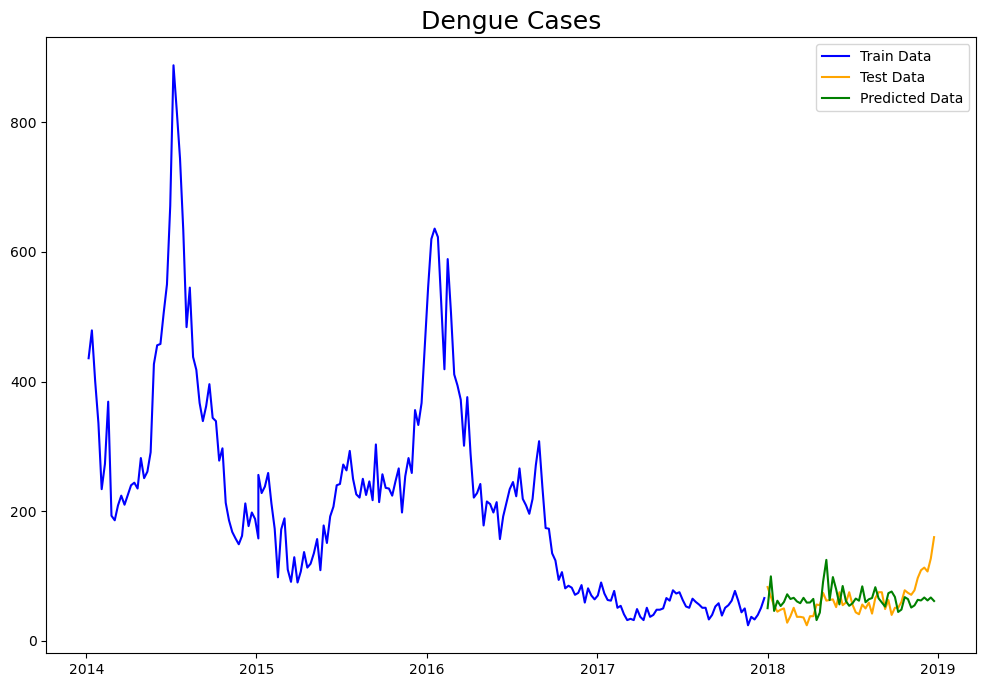

In [17]:
# Plotting predictions_mean and actual values
plot(predictions_mean000)

### Seasonal Order (0,0,1,26)


In [18]:
# fit SARIMAX model with exogenous variables
order = (0, 1, 1)
seasonal_order = (0, 0, 1, 26)
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_fit001 = model.fit()


C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Extration of AIC and LLF
extract_aic_lif(model_fit001)

                                     SARIMAX Results                                      
Dep. Variable:                             number   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 26)   Log Likelihood               -1089.280
Date:                            Fri, 21 Apr 2023   AIC                           2230.559
Time:                                    00:00:20   BIC                           2317.335
Sample:                                         0   HQIC                          2265.647
                                            - 209                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)        -0.2744      2.901     -0.095      0.925   

In [20]:
# Getting predictions mean 
predictions_mean001=get_predictions_mean(model_fit001)

In [21]:
# Calculate RMSE
calculate_rmse(predictions_mean001)

RMSE: 29.224502719568296


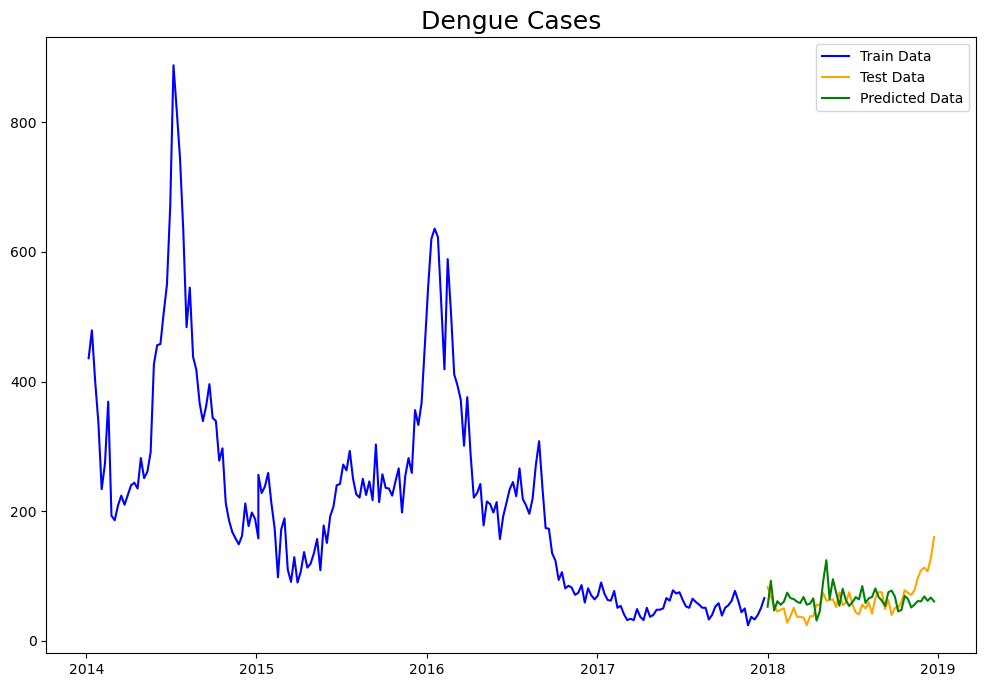

In [22]:
# Plotting predictions_mean and actual values
plot(predictions_mean001)

### Seasonal Order (0,1,0,26)


In [23]:
# fit SARIMAX model with exogenous variables
order = (0, 1, 1)
seasonal_order = (0, 1, 0, 26)
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_fit010 = model.fit()


C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Extraction of AIC and LLF
extract_aic_lif(model_fit010)

                                      SARIMAX Results                                      
Dep. Variable:                              number   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 26)   Log Likelihood                -997.571
Date:                             Fri, 21 Apr 2023   AIC                           2045.142
Time:                                     00:00:25   BIC                           2125.242
Sample:                                          0   HQIC                          2077.613
                                             - 209                                         
Covariance Type:                               opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)         0.3133      1.689      0.186      

In [25]:
# Getting predictions mean 
predictions_mean010=get_predictions_mean(model_fit010)

In [26]:
# Calculate RMSE
calculate_rmse(predictions_mean010)

RMSE: 34.456297084497294


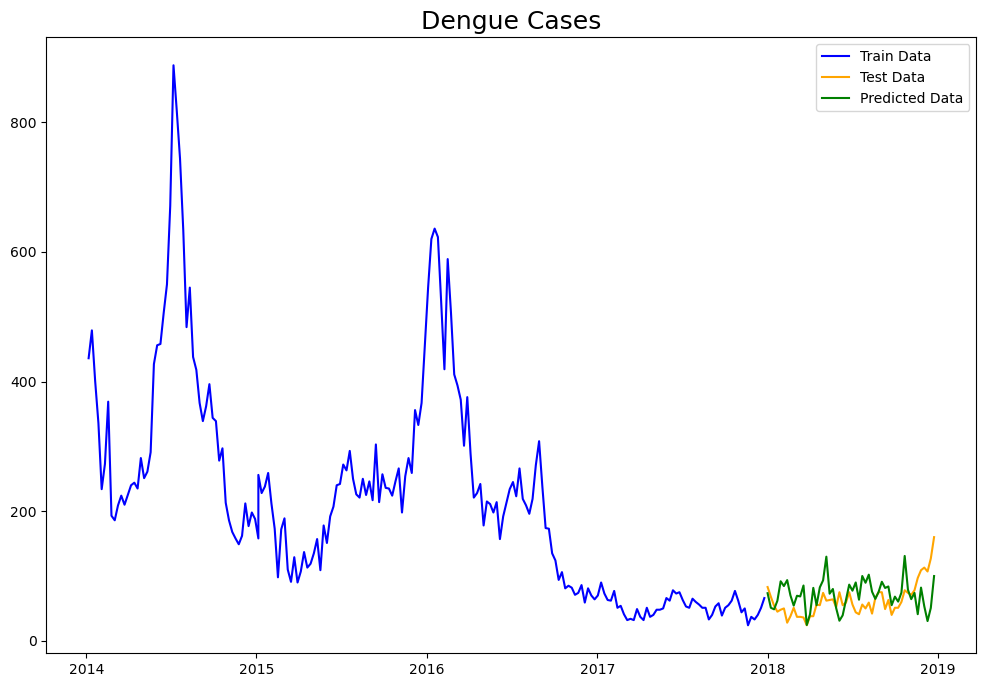

In [27]:
# Plotting predictions_mean and actual values
plot(predictions_mean010)

### Seasonal Order (1,0,0,26)


In [28]:
# fit SARIMAX model with exogenous variables
order = (0, 1, 1)
seasonal_order = (1, 0, 0, 26)
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_fit100 = model.fit()

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
# Extraction of AIC and LLF
extract_aic_lif(model_fit100)

                                      SARIMAX Results                                      
Dep. Variable:                              number   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 26)   Log Likelihood               -1089.283
Date:                             Fri, 21 Apr 2023   AIC                           2230.566
Time:                                     00:00:32   BIC                           2317.342
Sample:                                          0   HQIC                          2265.654
                                             - 209                                         
Covariance Type:                               opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)        -0.2686      2.944     -0.091      

In [30]:
# Getting predictions mean 
predictions_mean100=get_predictions_mean(model_fit100)

In [31]:
# Calculate RMSE
calculate_rmse(predictions_mean100)

RMSE: 29.18458776488713


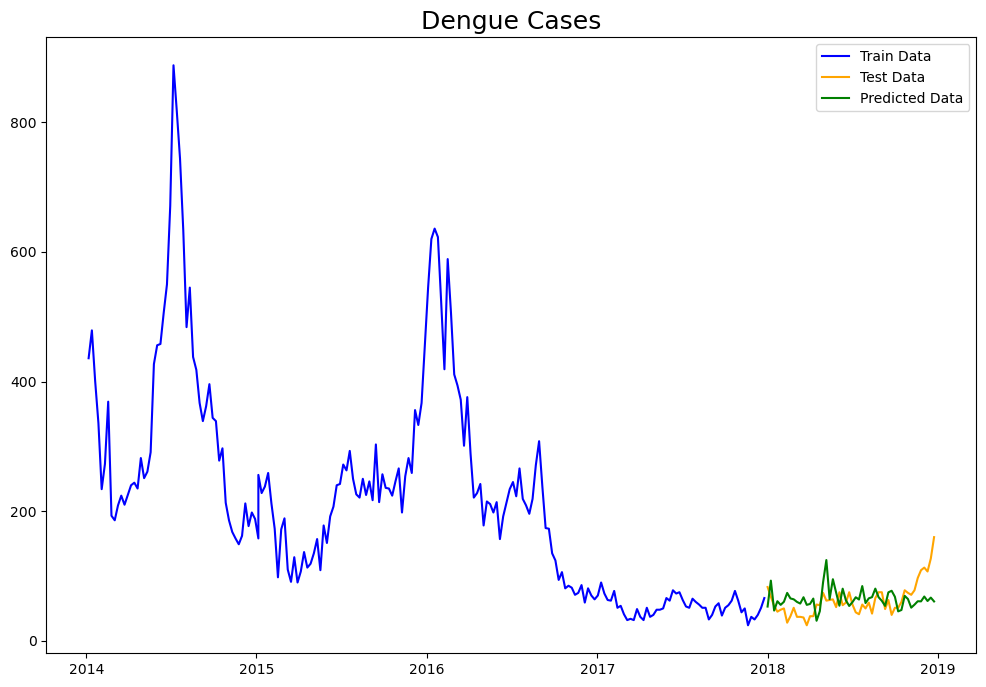

In [32]:
# Plotting predictions_mean and actual values
plot(predictions_mean100)

### Seasonal Order (1,1,1,26)


In [33]:
# fit SARIMAX model with exogenous variables
order = (0, 1, 1)
seasonal_order = (1, 1, 1, 26)
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order)
model_fit111 = model.fit()

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# Extraction of AIC and LLF
extract_aic_lif(model_fit111)

                                     SARIMAX Results                                      
Dep. Variable:                             number   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 26)   Log Likelihood                -976.520
Date:                            Fri, 21 Apr 2023   AIC                           2007.040
Time:                                    00:00:54   BIC                           2093.548
Sample:                                         0   HQIC                          2042.109
                                            - 209                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)         0.6656      1.316      0.506      0.613   

In [35]:
# Getting predictions mean 
predictions_mean111=get_predictions_mean(model_fit111)

In [36]:
# Calculate RMSE
calculate_rmse(predictions_mean111)

RMSE: 82.09045759661757


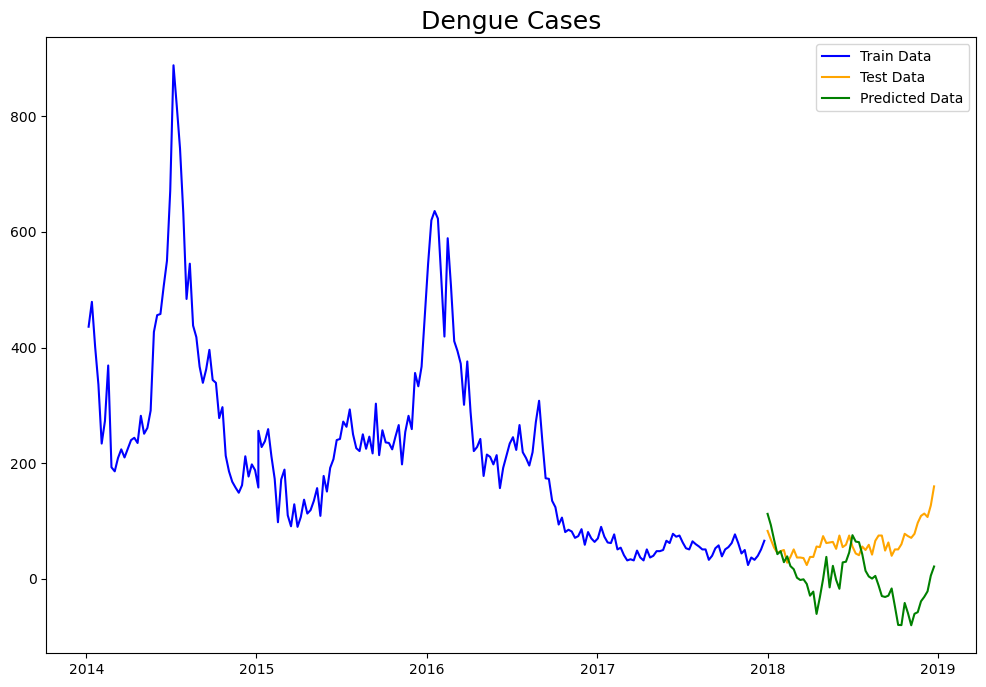

In [37]:
# Plotting predictions_mean and actual values
plot(predictions_mean111)

### AIC, Log Likelihood and RMSE Analysis

In [38]:
data = {'Seasonal Order': ['(0,0,0)', '(0,0,1)', '(0,1,0)', '(1,0,0)', '(1,1,1)'],
        'AIC': [2229.573, 2230.559, 2045.142, 2230.566, 2007.04],
        'Log Likelihood': [-1089.786, -1089.280, -997.571, -1089.23, -976.52],
        'RMSE': [29.44, 29.22, 34.46, 29.2, 82.09]}

# Creating dataframe for the AIC, Log Likelihood and RMSE for different Seasonal SARIMAX models
df = pd.DataFrame(data)
df.set_index('Seasonal Order', inplace=True)

# Show the Table of results
df

,AIC,Log Likelihood,RMSE
Seasonal Order,,,
"(0,0,0)",2229.573,-1089.786,29.44
"(0,0,1)",2230.559,-1089.280,29.22
"(0,1,0)",2045.142,-997.571,34.46
"(1,0,0)",2230.566,-1089.230,29.20
"(1,1,1)",2007.040,-976.520,82.09


#### $\color{red}{\text{AIC, Log Likelihood and RMSE Analysis:}}$

As can be seen from the above table, the RMSE values for SARIMAX models with seasonal order (0,1,0 and (1,1,1) are are high as compared to the rest. The Dengue Cases plot for both of these models shows that the predicted values are not much aligned with the actual test values. Hence, we will discard these 2 models for the next Forecast Study.

## Forecast Study

### Preparation of Exogenous Data for 2019

In [40]:
# Reading in the 2019 weather and google trends data
weekly_rain2019=pd.read_csv('../../assets/weekly_rain2019.csv', index_col=0)
google2019=pd.read_csv('../../assets/google2019.csv', index_col=0)

In [41]:
weekly_rain2019.head()

,date,Daily Rainfall Total (mm),Highest 30-min Rainfall (mm),Highest 60-min Rainfall (mm),Highest 120-min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,2019-01-07,12.43,3.74,5.14,6.0,26.59,30.31,24.36,7.14,26.97
1,2019-01-14,0.00,0.00,0.00,0.0,27.59,31.40,25.14,11.53,35.99
2,2019-01-21,1.29,0.86,0.89,1.0,27.53,31.56,25.29,11.61,36.23
3,2019-01-28,0.00,0.00,0.00,0.0,27.87,32.64,24.91,9.91,31.74
4,2019-02-04,0.57,0.57,0.60,0.6,28.27,32.99,25.39,11.43,32.27


In [42]:
weekly_rain2019=weekly_rain2019.rename(columns={'Highest 30-min Rainfall (mm)':'Highest 30 Min Rainfall (mm)',
                                'Highest 60-min Rainfall (mm)':'Highest 60 Min Rainfall (mm)',
                                'Highest 120-min Rainfall (mm)':'Highest 120 Min Rainfall (mm)'})

In [43]:
weekly_rain2019.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,2019-01-07,12.43,3.74,5.14,6.0,26.59,30.31,24.36,7.14,26.97
1,2019-01-14,0.00,0.00,0.00,0.0,27.59,31.40,25.14,11.53,35.99
2,2019-01-21,1.29,0.86,0.89,1.0,27.53,31.56,25.29,11.61,36.23
3,2019-01-28,0.00,0.00,0.00,0.0,27.87,32.64,24.91,9.91,31.74
4,2019-02-04,0.57,0.57,0.60,0.6,28.27,32.99,25.39,11.43,32.27


In [44]:
google2019.head()

,date,fogging_search,dengue_fever_search,dengue_search,dengue_symptoms_search,fever_search,headache_search,insect_repellent_search,mosquito_search,nausea_search,rashes_search,vomiting_search,wolbachia_search,eye_pain_search,joint_pain_search
0,2019-01-07,0,37,38,15,77,60,29,52,70,59,74,0,33,85
1,2019-01-14,0,35,37,23,69,75,0,66,76,52,85,12,0,64
2,2019-01-21,0,37,39,26,67,69,36,58,68,55,68,16,0,58
3,2019-01-28,0,27,29,11,70,89,0,61,73,36,70,17,0,43
4,2019-02-04,0,39,45,9,65,81,0,55,76,28,72,0,0,61


In [45]:
# merging google2019 and weekly_rain2019 in a single dataframe
rain_google2019=pd.merge(weekly_rain2019, google2019, on='date')

In [46]:
rain_google2019.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),...,fever_search,headache_search,insect_repellent_search,mosquito_search,nausea_search,rashes_search,vomiting_search,wolbachia_search,eye_pain_search,joint_pain_search
0,2019-01-07,12.43,3.74,5.14,6.0,26.59,30.31,24.36,7.14,26.97,...,77,60,29,52,70,59,74,0,33,85
1,2019-01-14,0.00,0.00,0.00,0.0,27.59,31.40,25.14,11.53,35.99,...,69,75,0,66,76,52,85,12,0,64
2,2019-01-21,1.29,0.86,0.89,1.0,27.53,31.56,25.29,11.61,36.23,...,67,69,36,58,68,55,68,16,0,58
3,2019-01-28,0.00,0.00,0.00,0.0,27.87,32.64,24.91,9.91,31.74,...,70,89,0,61,73,36,70,17,0,43
4,2019-02-04,0.57,0.57,0.60,0.6,28.27,32.99,25.39,11.43,32.27,...,65,81,0,55,76,28,72,0,0,61


In [47]:
# setting date for rain_google2019 as index
rain_google2019=rain_google2019.set_index('date')

In [48]:
rain_google2019.head()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),fogging_search,...,fever_search,headache_search,insect_repellent_search,mosquito_search,nausea_search,rashes_search,vomiting_search,wolbachia_search,eye_pain_search,joint_pain_search
date,,,,,,,,,,,,,,,,,,,,,
2019-01-07,12.43,3.74,5.14,6.0,26.59,30.31,24.36,7.14,26.97,0,...,77,60,29,52,70,59,74,0,33,85
2019-01-14,0.00,0.00,0.00,0.0,27.59,31.40,25.14,11.53,35.99,0,...,69,75,0,66,76,52,85,12,0,64
2019-01-21,1.29,0.86,0.89,1.0,27.53,31.56,25.29,11.61,36.23,0,...,67,69,36,58,68,55,68,16,0,58
2019-01-28,0.00,0.00,0.00,0.0,27.87,32.64,24.91,9.91,31.74,0,...,70,89,0,61,73,36,70,17,0,43
2019-02-04,0.57,0.57,0.60,0.6,28.27,32.99,25.39,11.43,32.27,0,...,65,81,0,55,76,28,72,0,0,61


### Reading in the 'unseen' 2019 Dengue Data

In [49]:
# Reading in dengue cases for 2019
dengue2019=pd.read_csv('../../assets/2019dengue_cases.csv')

In [50]:
dengue2019.head()

,Year,Week No.,Daily Rainfall Total (mm),Mean Temperature (C),Dengue (Count)
0,2012,1,1.839990,27.065217,74
1,2012,2,3.488352,26.472771,66
2,2012,3,15.048955,27.200941,61
3,2012,4,1.376449,26.809944,52
4,2012,5,8.257399,26.558095,85


In [51]:
dengue2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       412 non-null    int64  
 1   Week No.                   412 non-null    int64  
 2   Daily Rainfall Total (mm)  412 non-null    float64
 3   Mean Temperature (C)       412 non-null    float64
 4   Dengue (Count)             412 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 16.2 KB


In [52]:
dengue2019=dengue2019.loc[dengue2019['Year']==2019]

In [53]:
dengue2019.head()

,Year,Week No.,Daily Rainfall Total (mm),Mean Temperature (C),Dengue (Count)
365,2019,1,1.836928,28.529989,207
366,2019,2,3.189001,28.219524,245
367,2019,3,8.001679,27.703571,215
368,2019,4,0.426999,27.855661,222
369,2019,5,0.160633,27.959816,182


In [54]:
# create a date range for the DataFrame with Monday as starting day of the week
date_range = pd.date_range(start='2018-12-31', periods=len(dengue2019), freq='W')+ pd.Timedelta(days=1)

# assign the date range to the DataFrame's index
dengue2019.index = date_range

In [55]:
dengue2019.head()

,Year,Week No.,Daily Rainfall Total (mm),Mean Temperature (C),Dengue (Count)
2019-01-07,2019,1,1.836928,28.529989,207
2019-01-14,2019,2,3.189001,28.219524,245
2019-01-21,2019,3,8.001679,27.703571,215
2019-01-28,2019,4,0.426999,27.855661,222
2019-02-04,2019,5,0.160633,27.959816,182


In [56]:
dengue2019=dengue2019.rename(columns={'Dengue (Count)':'number'})

In [57]:
rain_google2019.columns

Index(['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'fogging_search', 'dengue_fever_search',
       'dengue_search', 'dengue_symptoms_search', 'fever_search',
       'headache_search', 'insect_repellent_search', 'mosquito_search',
       'nausea_search', 'rashes_search', 'vomiting_search', 'wolbachia_search',
       'eye_pain_search', 'joint_pain_search'],
      dtype='object')

In [58]:
# Creating exogenous variables for 2019
exog2019 = rain_google2019[['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'fogging_search', 'dengue_fever_search',
       'dengue_search', 'dengue_symptoms_search', 'fever_search',
       'headache_search', 'insect_repellent_search', 'mosquito_search',
       'nausea_search', 'rashes_search', 'vomiting_search', 'wolbachia_search',
       'eye_pain_search', 'joint_pain_search']]

### Forecast Analysis

### Seasonal Order (0,0,0,26)


In [59]:
forecast000=model_fit000.forecast(steps=52, exog=exog2019)

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


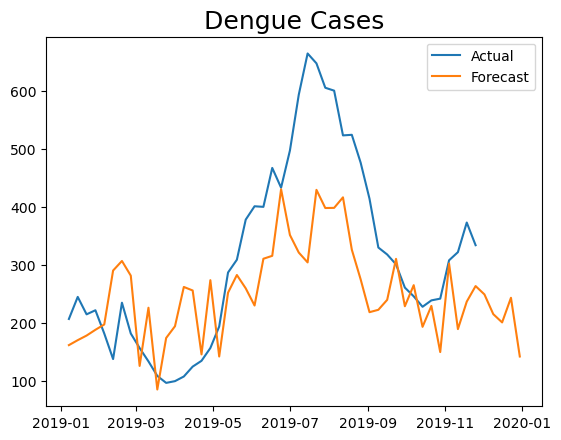

In [60]:
# create a date range for the forecast period
forecast_period = pd.date_range(start=rain_google2019.index[0], periods=52, freq='W-MON')

# plot the actual dengue cases for 2019
plt.plot(dengue2019.index, dengue2019['number'], label='Actual')

# plot the forecast against the date range
plt.plot(forecast_period, forecast000.values, label='Forecast')
plt.title(label='Dengue Cases', fontsize=18)
plt.legend()
plt.show();

### Seasonal Order (0,0,1,26)


In [61]:
forecast001=model_fit001.forecast(steps=52, exog=exog2019)

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


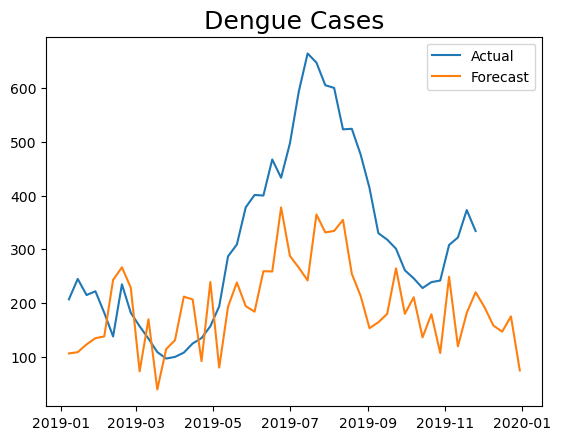

In [62]:
# create a date range for the forecast period
forecast_period = pd.date_range(start=rain_google2019.index[0], periods=52, freq='W-MON')

# plot the actual dengue cases for 2019
plt.plot(dengue2019.index, dengue2019['number'], label='Actual')

# plot the forecast against the date range
plt.plot(forecast_period, forecast001.values, label='Forecast')
plt.title(label='Dengue Cases', fontsize=18)
plt.legend()
plt.show();

### Seasonal Order (1,0,0,26)


In [63]:
forecast100=model_fit100.forecast(steps=52, exog=exog2019)

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


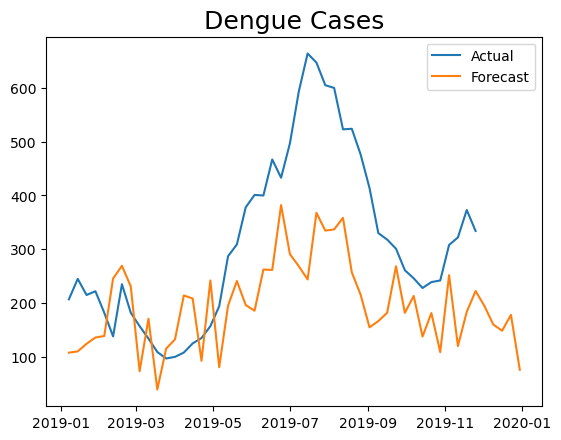

In [64]:
# create a date range for the forecast period
forecast_period = pd.date_range(start=rain_google2019.index[0], periods=52, freq='W-MON')

# plot the actual dengue cases for 2019
plt.plot(dengue2019.index, dengue2019['number'], label='Actual')

# plot the forecast against the date range
plt.plot(forecast_period, forecast100.values, label='Forecast')
plt.title(label='Dengue Cases', fontsize=18)
plt.legend()
plt.show();

### $\color{red}{\text{Forecast Study Analysis:}}$

The Forecast plot for the SARIMAX model with seasonal order (0,0,0) is the most closest to the 'unseen' actual Dengue values 2019 as compared to the other 2 SARIMAX models. Hence, we will use SARIMAX model with non-seasonal order (0,1,1) and seasonal order (0,0,0).